# Imports and configs

In [1]:
!pip install autogluon.tabular scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e7/train.csv"
    test_path = "/kaggle/input/playground-series-s5e7/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e7/sample_submission.csv"
    
    target = "Personality"
    n_folds = 5
    seed = 42
    
    log_path = "/logs"
    time_limit = 3600 * 11

# Loading data and defining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path=CFG.log_path,
    problem_type="binary",
    eval_metric="roc_auc",
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [7]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality"
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.26 GB / 31.35 GB (96.5%)
Disk Space Avail:   1704.25 GB / 8062.39 GB (21.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

[1000]	valid_set's binary_logloss: 0.123521


	0.9705	 = Validation score   (roc_auc)
	5.97s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 5879.57s of the 9180.70s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9678	 = Validation score   (roc_auc)
	180.36s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 5699.00s of the 9000.14s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9681	 = Validation score   (roc_auc)
	8.6s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 5689.94s of the 8991.07s of remaining time.
	Forcing `use_child_oof=False` because `groups` is specified
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.964	 = Validation score   (roc_auc)
	6.77s	 = 

[1000]	valid_set's binary_logloss: 0.123204
[1000]	valid_set's binary_logloss: 0.133956
[1000]	valid_set's binary_logloss: 0.143057
[1000]	valid_set's binary_logloss: 0.125486
[1000]	valid_set's binary_logloss: 0.113199


	0.9705	 = Validation score   (roc_auc)
	19.45s	 = Training   runtime
	2.26s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 4263.06s of the 7564.19s of remaining time.
	Forcing `use_child_oof=False` because `groups` is specified
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9647	 = Validation score   (roc_auc)
	9.49s	 = Training   runtime
	0.58s	 = Validation runtime
Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 4252.34s of the 7553.48s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9704	 = Validation score   (roc_auc)
	20.18s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 4232.09s of the 7533.23s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.969	 = Validation score   (roc_auc)
	253

[1000]	valid_set's binary_logloss: 0.123517


	0.9721	 = Validation score   (roc_auc)
	8.34s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 2402.03s of the 2401.83s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9711	 = Validation score   (roc_auc)
	154.68s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 2246.77s of the 2246.57s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.971	 = Validation score   (roc_auc)
	31.08s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 2215.14s of the 2214.94s of remaining time.
	Forcing `use_child_oof=False` because `groups` is specified
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9702	 = Validation score   (roc_auc)
	19.18s	

[1000]	valid_set's binary_logloss: 0.122467
[1000]	valid_set's binary_logloss: 0.13302
[1000]	valid_set's binary_logloss: 0.142271
[1000]	valid_set's binary_logloss: 0.125313
[1000]	valid_set's binary_logloss: 0.111148


	0.9729	 = Validation score   (roc_auc)
	34.85s	 = Training   runtime
	2.24s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 133.67s of the 133.47s of remaining time.
	Forcing `use_child_oof=False` because `groups` is specified
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping RandomForest_r39_BAG_L2.
Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 73.06s of the 72.86s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9718	 = Validation score   (roc_auc)
	39.27s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L2 ... Training model for up to 33.62s of the 33.42s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping t

[1000]	valid_set's binary_logloss: 0.124172
[1000]	valid_set's binary_logloss: 0.13468
[1000]	valid_set's binary_logloss: 0.138912
[1000]	valid_set's binary_logloss: 0.125248
[1000]	valid_set's binary_logloss: 0.119378


	0.9705	 = Validation score   (roc_auc)
	19.33s	 = Training   runtime
	2.55s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 27261.36s of the 27261.35s of remaining time.
	Forcing `use_child_oof=False` because `groups` is specified
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.965	 = Validation score   (roc_auc)
	10.38s	 = Training   runtime
	0.56s	 = Validation runtime
Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 27249.83s of the 27249.82s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.97	 = Validation score   (roc_auc)
	21.05s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 27228.71s of the 27228.70s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.9695	 = Validation score   (roc_auc)

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.971989,roc_auc,1.758570,686.882952,0.004887,2.935858,2,True,111
1,LightGBM_r42_BAG_L1,0.970893,roc_auc,0.098366,4.233625,0.098366,4.233625,1,True,108
2,XGBoost_r31_BAG_L1,0.970770,roc_auc,0.343549,9.661943,0.343549,9.661943,1,True,77
3,LightGBM_r94_BAG_L1,0.970719,roc_auc,0.174273,3.970927,0.174273,3.970927,1,True,61
4,LightGBM_r196_BAG_L1,0.970507,roc_auc,2.551408,19.334065,2.551408,19.334065,1,True,44
5,XGBoost_r95_BAG_L1,0.970492,roc_auc,0.083105,4.001443,0.083105,4.001443,1,True,106
6,LightGBM_r96_BAG_L1,0.970468,roc_auc,0.474703,5.685183,0.474703,5.685183,1,True,19
7,CatBoost_r6_BAG_L1,0.970356,roc_auc,0.032195,14.903498,0.032195,14.903498,1,True,85
8,CatBoost_r163_BAG_L1,0.970330,roc_auc,0.018281,13.949456,0.018281,13.949456,1,True,102
9,CatBoost_r69_BAG_L1,0.970293,roc_auc,0.022113,20.214746,0.022113,20.214746,1,True,37


In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

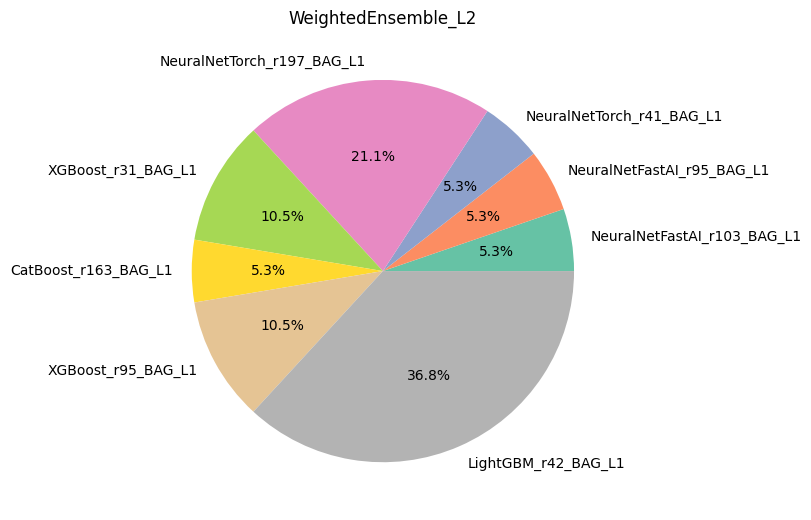

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Saving OOF files and creating a submission file

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = "oof_pred_probs" if type == "oof" else "test_pred_probs"
    base_path = "." if is_ensemble else base_path
    with open(f"{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl", "wb") as f:
        pickle.dump(pred_probs, f)

def save_submission(test_preds, score):        
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_preds
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_pred_probs", exist_ok=True)
os.makedirs("test_pred_probs", exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}
oof_preds = {}

In [13]:
best_model = predictor.model_best
_test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_oof_preds = predictor.predict_oof(model).values
    model_test_pred_probs = _test_pred_probs[model].values[:, 1]
    
    cv_score = accuracy_score(train[CFG.target], model_oof_preds)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", False)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", True)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", True)
        save_submission(predictor.predict(test).values, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs
    oof_preds[model] = model_oof_preds

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = accuracy_score(train.loc[val_index, CFG.target], oof_preds[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

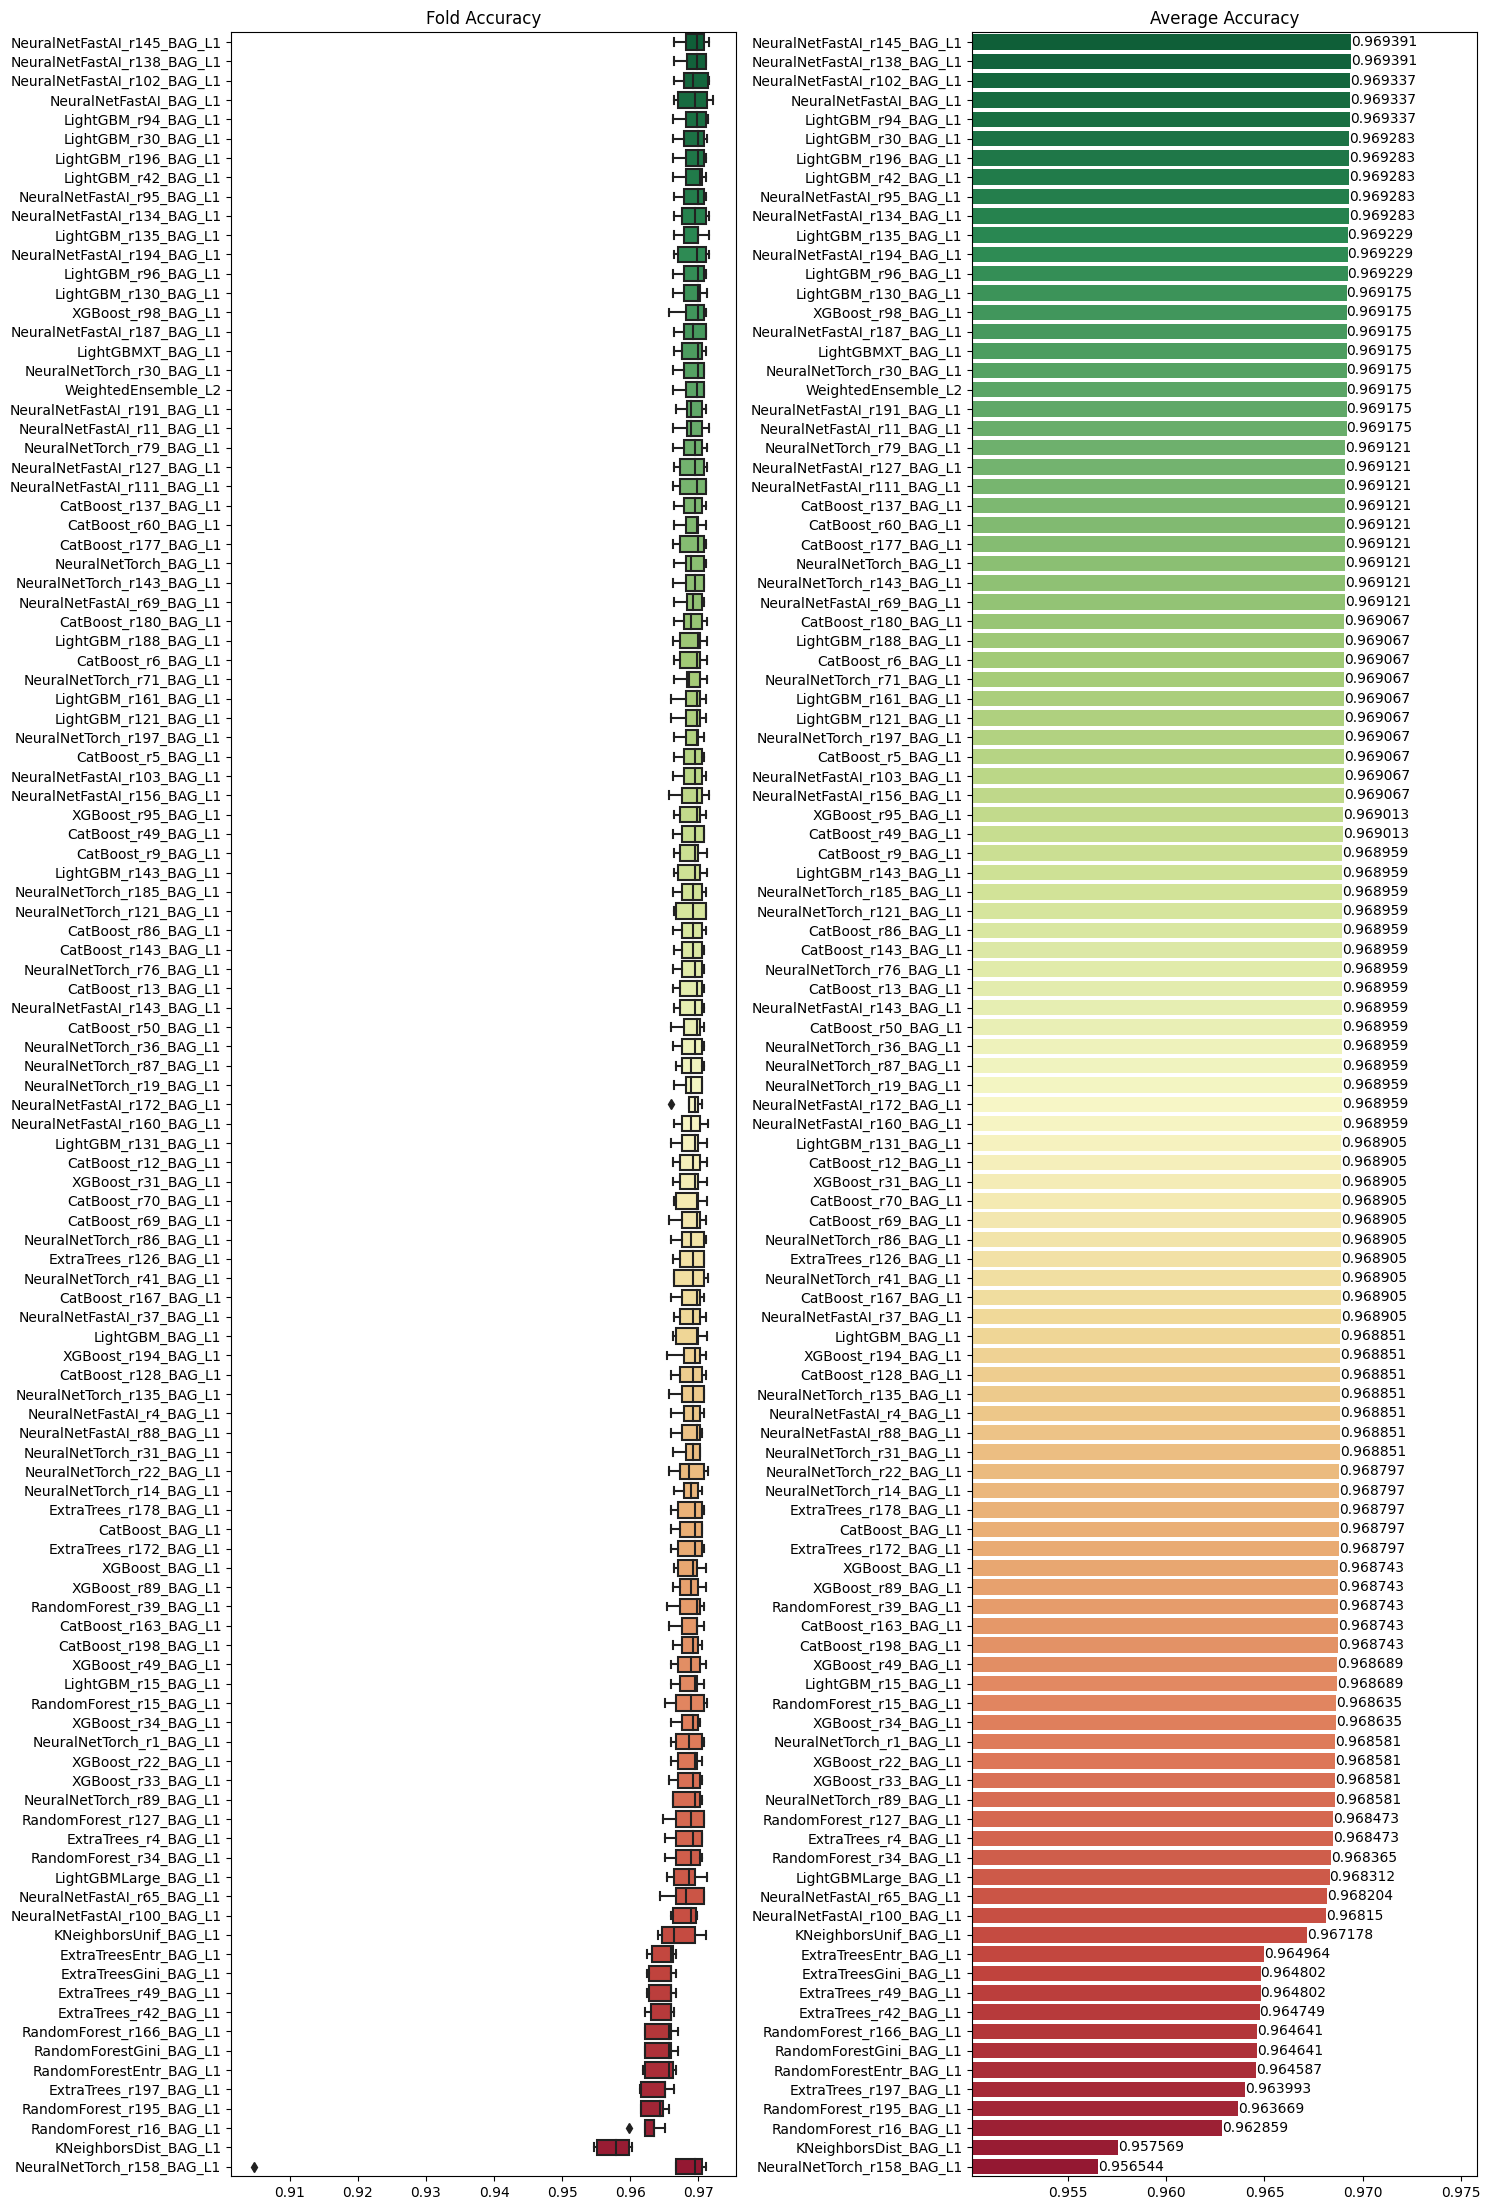

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold Accuracy")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average Accuracy")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()